# Introduction

Time series modeling is a set of tools and techniques that model temporal or time series data and aim to predict or forecast future behavior of the data. It has applications in various fields such as finance, economics, weather forecasting, and more.

By analyzing historical data, we can identify different components in time series data such as trends, seasonality, and so on, and use these insights to make more informed business decisions.

In this demonstration, we will explore a few different techniques for time series modeling. As we construct and evaluate our models, we'll gain insight into how different techniques can be used to handle common challenges in time series modeling.


## Problem Statement
In  this demonstration, we will apply time series modeling techniques to a real-world problem that involves a company and its sales. The company has historical sales data that it has captured over a period of time and wishes to forecast future sales trends so that it may optimize its inventory management processes.

The problem statement for this demonstration can be summarized as follows:
> Given historical sales data of a company, forecast its future sales.

By studying the forecast, the company can effectively plan and prepare their inventory to ensure that the right amount of stock is made ready over future months.

## Data Description
You have been provided with a data set containing daily sales and profit data of the company for the period 2011 to 2014. The data set has the following three attributes:

<table>
  <tr>
    <th> Attributes </th>
    <th> Description <th>
  </tr>
  <tr>
    <td> Order-Date </td>
    <td> The date on which the order was placed (in dd-mm-yyyy format) </td>
  </tr>
  <tr>
    <td> Sales </td>
    <td> Total sales value of the transaction (in dollars) </td>
  </tr>
  <tr>
    <td> Profit </td>
    <td> Profit made on the transaction (in dollars) </td>
  </tr>

</table>

## Outline
In this demonstration, we will:
- Prepare the data for time series modeling
- Forecast sales using the following models:
  - Autoregressive (AR)
  - Autoregressive integrated moving average (ARIMA)
  - Seasonal autoregressive integrated moving average (SARIMA)

We will analyze the performance of these models using root mean squared error (RMSE) and mean absolute percentage error (MAPE).

Please note that while we could evaluate the performance of the forecasting models using any one of RMSE or MAPE, to obtain a more comprehensive assessment of their performance, we will use both measures for each model.

# Part 1 - Setup and Data Preparation
In this section, we will:
- Import necessary packages for executing the code
- Load the data
- Prepare the data for further analysis

In [ ]:
# Import 'numpy' and 'pandas' for working with numbers and dataframes
import numpy as np
import pandas as pd

# Import 'pyplot' from 'matplotlib' and 'seaborn' for visualizations
from matplotlib import pyplot as plt
import seaborn as sns

# Import and execute method for suppressing warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

Let's begin by loading the data and building familiarity with it.

In [ ]:
data = pd.read_csv('Superstore_Data.csv')

In [ ]:
data.head()

,Order Date,Sales,Profit
0,17-10-2013,5175.171,919.971
1,07-11-2011,1822.080,564.840
2,14-04-2012,5244.840,996.480
3,06-06-2013,3701.520,1036.080
4,25-02-2012,1878.720,582.360


In [ ]:
data.dtypes #print the datatype of the values present in each column

,0
Order Date,object
Sales,float64
Profit,float64


As you can see, the data type of the *Order Date* column is *object*. But to further conduct analyses on the data, such as grouping by month or year, we have to convert the data type of the *Order Date* column to *datetime*.

In [ ]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

In [ ]:
data.dtypes

,0
Order Date,datetime64[ns]
Sales,float64
Profit,float64


Let's make sure that the data points in the data frame are ordered by date.

In [ ]:
data.head()

,Order Date,Sales,Profit
0,2013-10-17,5175.171,919.971
1,2011-11-07,1822.080,564.840
2,2012-04-14,5244.840,996.480
3,2013-06-06,3701.520,1036.080
4,2012-02-25,1878.720,582.360


In [ ]:
data.sort_values(by = 'Order Date', inplace = True)

Next, we will set the updated *Order Date* feature as the index of the data frame.

In [ ]:
data.head()

,Order Date,Sales,Profit
5073,2011-01-01,55.242,15.342
3056,2011-01-01,120.366,36.036
4083,2011-01-01,113.670,37.770
424,2011-01-03,912.456,-319.464
5517,2011-01-03,6.006,0.546


In [ ]:
data.reset_index(drop = True, inplace = True)

In [ ]:
data.head()

,Order Date,Sales,Profit
0,2011-01-01,55.242,15.342
1,2011-01-01,120.366,36.036
2,2011-01-01,113.670,37.770
3,2011-01-03,912.456,-319.464
4,2011-01-03,6.006,0.546


In [ ]:
#set the ORDER Date column as the index of the data
data.set_index('Order Date', inplace = True)

In [ ]:
data.head()

,Sales,Profit
Order Date,,
2011-01-01,55.242,15.342
2011-01-01,120.366,36.036
2011-01-01,113.670,37.770
2011-01-03,912.456,-319.464
2011-01-03,6.006,0.546


In [ ]:
data.loc['2011-01-01']

,Sales,Profit
Order Date,,
2011-01-01,55.242,15.342
2011-01-01,120.366,36.036
2011-01-01,113.670,37.770


In [ ]:
data['2011-01-01' : '2011-03-10']

,Sales,Profit
Order Date,,
2011-01-01,55.242,15.342
2011-01-01,120.366,36.036
2011-01-01,113.670,37.770
2011-01-03,912.456,-319.464
2011-01-03,6.006,0.546
...,...,...
2011-03-08,316.764,13.944
2011-03-08,143.316,-12.804
2011-03-08,860.895,143.325


**Note:** When we change the index of the data, then to select the rows using new index we should this method  `df.loc["new_index"]`

To study monthly sales, we need to group the rows of *df* by month and sum up the values in each group. We will use the *Grouper* function in conjunction with the *groupby* operation for grouping. *Grouper* is a function in the *pandas* library that allow us to group time series data based on a specific frequency (*freq*) which in our case is monthly (*M*).

In [ ]:
data.shape

(5699, 2)

In [ ]:
data = data.groupby(pd.Grouper(freq = 'M')).sum()

In [ ]:
data.head()

,Sales,Profit
Order Date,,
2011-01-31,15711.7125,991.2825
2011-02-28,12910.8588,1338.8688
2011-03-31,19472.5632,3747.1632
2011-04-30,15440.3046,3846.4746
2011-05-31,24348.9723,3639.9423


In [ ]:
data.shape

(48, 2)

You can see that only one date from each month is used in the index as representative of each of those months.

Recall from the problem statement that we are interested in forecasting *Sales*. So, we can drop the *Profit* feature from our data set.

In [ ]:
data.head()

,Sales,Profit
Order Date,,
2011-01-31,15711.7125,991.2825
2011-02-28,12910.8588,1338.8688
2011-03-31,19472.5632,3747.1632
2011-04-30,15440.3046,3846.4746
2011-05-31,24348.9723,3639.9423


In [ ]:
data.drop(columns = 'Profit', inplace = True)

Let's now plot our data set to visualize our time series and try to identify patterns in it.

<Axes: xlabel='Order Date'>

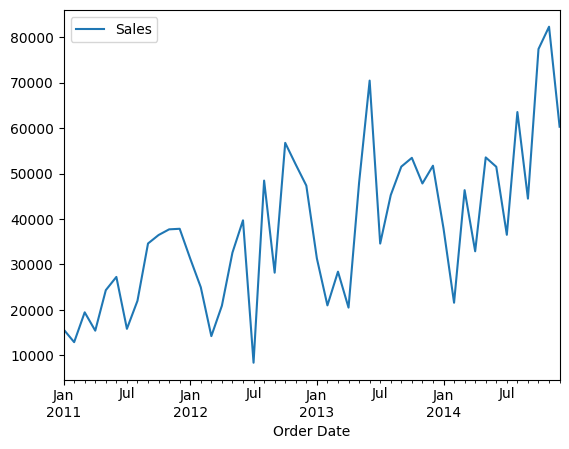

In [ ]:
data.plot()

# Part 2 - Stationarity Analysis
In this part of the demonstration, we will perform tests on the time series data to understand whether it is stationary or not. The autoregressive modeling requires the time series data to be stationary. To test this, we will use the following test:
- Augmented Dickey–Fuller (ADF) test

### ADF Test

Note that the null hypothesis for the ADF test is *The time series is not stationary*.

If the $p$-value is < $0.05$, then our data is stationary otherwise our data is non-stationary

We have analyzed our time series data. Let's now split the data into training and testing sets so that we're ready to build and evaluate time series models on the data.

In [ ]:
# Plot the time series data with the train-test split
plt.figure(figsize = (14, 6))
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue', label = 'Train')
sns.lineplot(data = df_test, x = 'Order Date', y = 'Sales', marker = 'o', color = 'green', label = 'Test')
plt.title('Sales Data');

# Part 3 - Time Series Transformations
Now we will transform the time series data so that it ends up having a more stationary mean and variance. To do this, we will use the following data transformations:
- Box-Cox transformation - makes the variance constant in any time series data.
- Differencing - make the mean constant in any time series data

Box-Cox transformation is used to make the variance of a time series stationary and differencing is used to make its mean stationary. Note that although these methods can be executed in any order, differencing is done after Box-Cox transformation in general.

### Subpart 1 - Box-Cox Transformation

The Box-Cox transformation is used to stabilize the variance of a time series. It involves the application of a power transformation to the time series data. Let's import the *boxcox* method from *scipy* to implement this transformation.

In [ ]:
# Import the 'boxcox' method from 'scipy' to implement the Box-Cox transformation


Note that from here on out, we will only perform data transformations on the training data to avoid data leakage.

In [ ]:
#we transformed the sales column with BCT and store the transformed version in the df_boxcox variable


In [ ]:
# Plot the original time series data and its Box-Cox transformed version
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Original Data')

plt.subplot(1, 2, 2)
sns.lineplot(x = df_boxcox.index, y = df_boxcox.values, marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Box-Cox Transformed Data [lambda = 0]')

plt.suptitle('Sales Data');

### Subpart 2 - Differencing

Differencing is used to stabilize the mean of a time series. It involves taking the difference of consecutive data points in the time series. If this process is executed once, it is known as first-order differencing. If done twice, it is called second-order differencing. And so on.

Note that differencing results in a missing value at the beginning of the series, but this is not of much consequence for the analysis.

In [ ]:
# Plot the original time series data and its first-order differenced version
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Original Data')

plt.subplot(1, 2, 2)
sns.lineplot(x = df_differenced.index, y = df_differenced.values, marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Differenced Data [Order = 1]')

plt.suptitle('Sales Data');

We will continue with difference order $=1$ for the remainder of the demonstration. However, you are free to analyze the impact of other order values on the mean of the time series data.

### Subpart 3 - Differencing + Box Cox Tranformation

We will now apply the Box-Cox and the differencing transformations on the training data so that the data is ready for autoregressive time series modeling.

In [ ]:
# Plot the original time series data and its transformed version
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Original Data')

plt.subplot(1, 2, 2)
sns.lineplot(x = df_boxcox_diff.index, y = df_boxcox_diff.values, marker = 'o', color = 'blue')
plt.xticks(rotation = 90)
plt.title('Transformed Data [lambda = 0 and differencing order = 1]')

plt.suptitle('Sales Data');

#### **Run the Adfuller test on the data, again after transformation to check whether our data has become stationary or not.**

- `df_boxcox_diff` is the variable where we have that version of our Sales data which has gone through BoxCox transformation and differencing both.

- we take `df_boxcox_diff[1:]` because the first value is null so we are ignoring the first value and running the test on the rest of the values.

# Part 4 - Autocorrelation Plots
In this part of the demonstration, we will compute and visualize the autocorrelation function (ACF) and the partial autocorrelation function (PACF) plots for the time series data.

### Subpart 1 - Autocorrelation Function (ACF) Plot

The autocorrelation function (ACF) plot shows the autocorrelation values of a time series for different lag orders. Let's import the *plot_acf* method from *statsmodels* to implement this.

In [ ]:
# Import 'plot_acf' from 'statsmodels' to compute and visualize the autocorrelation function (ACF) for the time series


In [ ]:
# Note: Since differencing results in a missing value at the beginning, we must exclude it


We can see a strong autocorrelation value at lag order $=1$. There is other lag order value where it is strong as well, such as $11$, but $1$ is the strongest.

In simple words, ACF measures the correlation between a time series with its lagged values.

If you have daily stock prices, the autocorrelation at lag 1 would measure how today's stock price relates to yesterday stock prices.

### Subpart 2 - Partial Autocorrelation Function (PACF) Plot

The partial autocorrelation fucntion (PACF) plot shows the partial autocorrelation values of a time series for different lag orders. Partial autocorrelation is computed such that it ignores short-term correlations in the data. Let's import the *plot_pacf* method from *statsmodels* to implement this.

In [ ]:
# Import 'plot_pacf' from 'statsmodels' to compute and visualize the partial autocorrelation function (ACF) for the time series


In [ ]:
# Note: Since differencing results in a missing value at the beginning, we must exclude it


# Part 5 - Autoregressive Models
In this part of the demonstration, we will fit autoregressive models to the data and anaylze their performance using RMSE and MAPE values. We will build the following models:
- Autoregressive (AR)
- Autoregressive integrated moving average (ARIMA)
- Seasonal autoregressive integrated moving average (SARIMA)

### Subpart 1 - Autoregressive (AR) Method

We will begin by fitting a basic autoregressive model to the training data and analyze its performance. We will use the *ARIMA* method from *statsmodels* to build the model.

**Note:** The *ARIMA* method can also be used to implement other autoregressive models.

Let's import the *ARIMA* method from *statsmodels*.

In [ ]:
# Import 'ARIMA' from 'statsmodels' for building autoregressive models
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Fit an AR model to the transformed training data with lag order 1 and view its optimal parameter values
# Note: You may try other suitable lag order values as well


In [ ]:
# Obtain predictions from the AR model for the testing data indices


In [ ]:
# Append the predictions with 'df_boxcox_diff' to prepare the data for inverse transformation


In [ ]:
# Reverse the differencing transformation that was done on the data


In [ ]:
# Reverse the Box-Cox transformation that was done on the data


Let's visualize the predictions along with the data before computing error measures.

In [ ]:
# Plot the time series data with the train-test split and the testing data predictions
plt.figure(figsize = (14, 6))
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue', label = 'Train')
sns.lineplot(data = df_test, x = 'Order Date', y = 'Sales', marker = 'o', color = 'green', label = 'Test')
sns.lineplot(x = df_preds.index[train_len:], y = df_preds.values[train_len:], marker = 'o', color = 'purple', label = 'Predictions')
plt.title('Sales Data');

Next, let's compute performance metrics for the model. But to do that, we will first import the *mean_squared_error* function from *sklearn*.

In [ ]:
# Import 'mean_squared_error' from 'sklearn' for error computations
from sklearn.metrics import mean_squared_error

In [ ]:
# Summarize the performance of the model on the test data using RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true = df_test['Sales'], y_pred = df_preds.values[train_len:]))

rmse = np.round(rmse, 2)

performance_df = pd.DataFrame(index = [0],data = {'Model': 'AR', 'RMSE': rmse})

performance_df.set_index('Model', inplace = True)

performance_df

### Autoregressive Integrated Moving Average (ARIMA) Method

We will now a fit an autoregressive integrated moving average model to the training data and analyze its performance. We will use the *ARIMA* method from *statsmodels* to build the model.

**Note:** The *ARIMA* method can also be used to implement other autoregressive models.

The parameter of interest in the *ARIMA* method is the *order* parameter. It is a 3-tuple of the form $(p, d, q)$ with the default value as $(0, 0, 0)$.

For the ARIMA method, we will specify all the values in this tuple. The first and the third values are the $p$ and $q$ values or the lag orders obtained from the PACF and the ACF plots respectively. The second value in the tuple is $d$ or the differencing order which we shall set as $1$.

**Note**: In ARIMA model, the differencing in already integrated, so we will use df_boxcox instead of df_boxcox_diff.

In [ ]:
# Fit an ARIMA model to the transformed training data with 'p = 1', 'd = 0' and 'q = 1' and view its optimal parameter values
# Note: Since differencing is integrated into the ARIMA method, we will use 'df_boxcox' instead of 'df_boxcox_diff'


In [ ]:
# Obtain predictions from the ARIMA model for the testing data indices


In [ ]:
# Append the predictions with 'df_boxcox' to prepare the data for inverse transformation


In [ ]:
# Reverse the Box-Cox transformation that was done on the data


Let's visualize the predictions along with the data before computing error measures.

In [ ]:
# Plot the time series data with the train-test split and the testing data predictions
plt.figure(figsize = (14, 6))
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue', label = 'Train')
sns.lineplot(data = df_test, x = 'Order Date', y = 'Sales', marker = 'o', color = 'green', label = 'Test')
sns.lineplot(x = df_preds.index[train_len:], y = df_preds.values[train_len:], marker = 'o', color = 'purple', label = 'Predictions')
plt.title('Sales Data');

Next, let's compute performance metrics for the model.

In [ ]:
# Summarize the performance of the model on the test data using RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true = df_test['Sales'], y_pred = df_preds.values[train_len:]))

rmse = np.round(rmse, 2)

performance_df_temp = pd.DataFrame(index = [0], data = {'Model': 'ARIMA', 'RMSE': rmse})

performance_df_temp.set_index('Model', inplace = True)

performance_df = pd.concat([performance_df, performance_df_temp])

performance_df

### Subpart 5 - Seasonal Autoregressive Integrated Moving Average (SARIMA) Method

We will now a fit a seasonal autoregressive integrated moving average model to the training data and analyze its performance. We will use the *SARIMAX* method from *statsmodels* to build the model.

Let's import the *SARIMAX* method from *statsmodels*.

In [ ]:
# Import 'SARIMAX' from 'statsmodels' for building autoregressive models
from statsmodels.tsa.statespace.sarimax import SARIMAX

The parameters of interest in the *SARIMAX* method are the *order* and the *seasonal_order* parameters. The *order* parameter is a 3-tuple of the form $(p, d, q)$ with the default value as $(0, 0, 0)$ and the *seasonal_order* parameter is a 4-tuple of the form $(P, D, Q, m)$ with the default value as $(0, 0, 0, 0)$.

For the SARIMA method, we will specify all the values in the two tuples.

The *seasonal_order* parameter specifies the lag and difference orders for the seasonal component of the model, along with its period.

In [ ]:
# Note: We know that the seasonality period in the data is 'm = 12'
# Note: Since differencing is integrated into the SARIMA method, we will use 'df_boxcox' instead of 'df_boxcox_diff'


In [ ]:
# Obtain predictions from the SARIMA model for the testing data indices


In [ ]:
# Append the predictions with 'df_boxcox' to prepare the data for inverse transformation


In [ ]:
# Reverse the Box-Cox transformation that was done on the data


Let's visualize the predictions along with the data before computing error measures.

In [ ]:
# Plot the time series data with the train-test split and the testing data predictions
plt.figure(figsize = (14, 6))
sns.lineplot(data = df_train, x = 'Order Date', y = 'Sales', marker = 'o', color = 'blue', label = 'Train')
sns.lineplot(data = df_test, x = 'Order Date', y = 'Sales', marker = 'o', color = 'green', label = 'Test')
sns.lineplot(x = df_preds.index[train_len:], y = df_preds.values[train_len:], marker = 'o', color = 'purple', label = 'Predictions')
plt.title('Sales Data');

Next, let's compute performance metrics for the model.

In [ ]:
# Summarize the performance of the model on the test data using RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_true = df_test['Sales'], y_pred = df_preds.values[train_len:]))

rmse = np.round(rmse, 2)

performance_df_temp = pd.DataFrame(index = [0], data = {'Model': 'SARIMA', 'RMSE': rmse})

performance_df_temp.set_index('Model', inplace = True)

performance_df = pd.concat([performance_df, performance_df_temp])

performance_df